

```
`# This is formatted as code`
```

#Google Analytics 4 (GA4) Data in Pyton

In [ ]:
#Import Libraries
import numpy as np
import pandas as pd
import os


In [ ]:
#Install Google Analytics Data Packages
!pip install google-analytics-data
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange
from google.analytics.data_v1beta.types import Dimension
from google.analytics.data_v1beta.types import Metric
from google.analytics.data_v1beta.types import RunReportRequest
from google.analytics.data_v1beta.types import OrderBy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 1.6 MB/s eta 0:00:00


In [ ]:
## Set up global variables

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'nameofserviceaccountjson.json'
property_id = 'yourgoogleanalyticspropertyid'

client = BetaAnalyticsDataClient()

In [ ]:
## Format Report - run_report method
def format_report(request):
    response = client.run_report(request)

    # Row index
    row_index_names = [header.name for header in response.dimension_headers]
    row_header = []
    for i in range(len(row_index_names)):
        row_header.append([row.dimension_values[i].value for row in response.rows])

    row_index_named = pd.MultiIndex.from_arrays(np.array(row_header), names = np.array(row_index_names))
    # Row flat data
    metric_names = [header.name for header in response.metric_headers]
    data_values = []
    for i in range(len(metric_names)):
        data_values.append([row.metric_values[i].value for row in response.rows])

    output = pd.DataFrame(data = np.transpose(np.array(data_values, dtype = 'f')),
                          index = row_index_named, columns = metric_names)
    return output

In [ ]:
#Simple Data Report
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month"),
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="averageSessionDuration"),
                 Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date="2022-06-01", end_date="today")],
    )

request

property: "properties/413050586"
dimensions {
  name: "month"
}
dimensions {
  name: "sessionMedium"
}
metrics {
  name: "averageSessionDuration"
}
metrics {
  name: "activeUsers"
}
date_ranges {
  start_date: "2022-06-01"
  end_date: "today"
}
order_bys {
  dimension {
    dimension_name: "month"
  }
}
order_bys {
  dimension {
    dimension_name: "sessionMedium"
  }
}

In [ ]:
#Output of the report
format_report(request)

averageSessionDuration  activeUsers
month sessionMedium                                     
01    (none)                     127.940689        260.0
      (not set)                    1.999154          3.0
      mail                        23.995478          1.0
      organic                    201.636871       1189.0
      referral                   230.507599        122.0
02    (none)                      79.752228        234.0
      (not set)                    2.670684          2.0
      organic                    160.913025        729.0
      referral                   175.213882        119.0
10    (none)                     112.210213         60.0
      organic                    161.394348        229.0
      referral                   138.656693         30.0
11    (none)                     190.172913        223.0
      (not set)                    6.538232          1.0
      mail                        24.301548          2.0
      organic                    178.545654       1038.0
      referral                   148.256149        136.0
12    (none)                     131.981796        108.0
      (not set)                    0.000000          1.0
      mail                        25.926308          2.0
      organic                    165.151016        626.0
      referral                   225.006119         46.0

In [ ]:
output_df = format_report(request)

# GA4 Monthly Traffic Chart

In [ ]:
#Import Packages
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Defining the montly user Report
monhtly_users_pivot = pd.pivot_table(output_df,
                                     columns=['sessionMedium'],
                                     index=['month'],
                                     values=['activeUsers'],
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)

In [ ]:
#Output of the report
monhtly_users_pivot

sessionMedium,(none),(not set),mail,organic,referral
month,,,,,
01,260,3,1,1189,122
02,234,2,0,729,119
10,60,0,0,229,30
11,223,1,2,1038,136
12,108,1,2,626,46


# Time Series Forecasting

In [ ]:
# Set up GA4 request
request = {
  "property": "properties/413050586", #input your property ID from Google Analytics 4 admin settings
  "date_ranges": [
    {
      "start_date": "2023-01-01", #adjust to your start date
      "end_date": "2024-12-28" #adjust to your end date
    }
  ],
  "dimensions": [   #input the dimensions you need
    {
      "name": "date"
    },
  ],
  "metrics": [ #input the metrics you need
    {
      "name": "sessions"
    },
  ]
}
# Execute GA4 request
response = client.run_report(request)

# Extract GA4 data into pandas DataFrame
data = []
for row in response.rows:
    dimension_values = [value.value for value in row.dimension_values]
    metric_values = [value.value for value in row.metric_values]
    data.append(dimension_values + metric_values)

columns = [dimension.name for dimension in response.dimension_headers] + [metric.name for metric in response.metric_headers]
df_sessions = pd.DataFrame(data, columns=columns)

In [ ]:
# Restructing the DataFrame and changing varible types
df = df_sessions
df['ds'] = pd.to_datetime(df['date'])
df['sessions'] = df['sessions'].astype('int')
df.rename(columns={'sessions': 'y'}, inplace= True)
df.drop(['date'], axis=1, inplace=True)

In [ ]:
#Checking Variables
request

{'property': 'properties/413050586',
 'date_ranges': [{'start_date': '2023-01-01', 'end_date': '2024-12-28'}],
 'dimensions': [{'name': 'date'}],
 'metrics': [{'name': 'sessions'}]}

In [ ]:
#Installing Facebook Prophet and Packages
!pip install prophet
import prophet

In [ ]:
#Import Facebook Prophet
import pandas as pd
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

<Axes: xlabel='ds'>

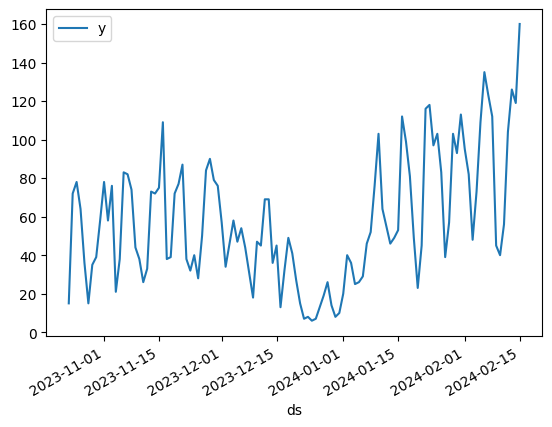

In [ ]:
#Simple Graph that shows the site session Numbers overtime
df.plot(x='ds', y='y')

<Axes: >

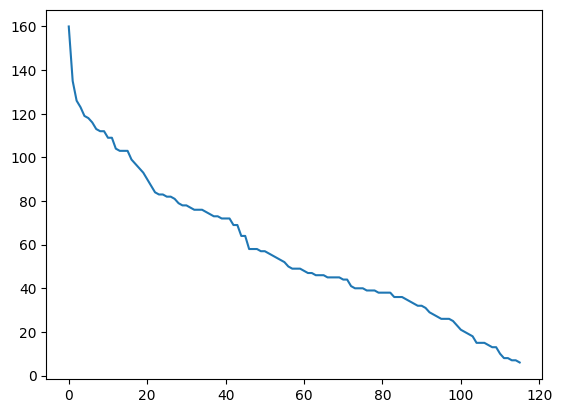

In [ ]:
#Plotted the Y Value
df['y'].plot()

In [ ]:
#Using Prophet to build a model for Forecasting
model = Prophet(interval_width = 0.95, daily_seasonality = True)
model.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ul48dz7/ahlq8smj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ul48dz7/cb18us19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44448', 'data', 'file=/tmp/tmp0ul48dz7/ahlq8smj.json', 'init=/tmp/tmp0ul48dz7/cb18us19.json', 'output', 'file=/tmp/tmp0ul48dz7/prophet_modele3qbt_ic/prophet_model-20240216204936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:49:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:49:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Specifiying Floor and Limits
future = model.make_future_dataframe(periods= 60)
future['cap'] = 120
future['floor'] = 0
print(future.tail())

            ds  cap  floor
171 2024-04-11  120      0
172 2024-04-12  120      0
173 2024-04-13  120      0
174 2024-04-14  120      0
175 2024-04-15  120      0


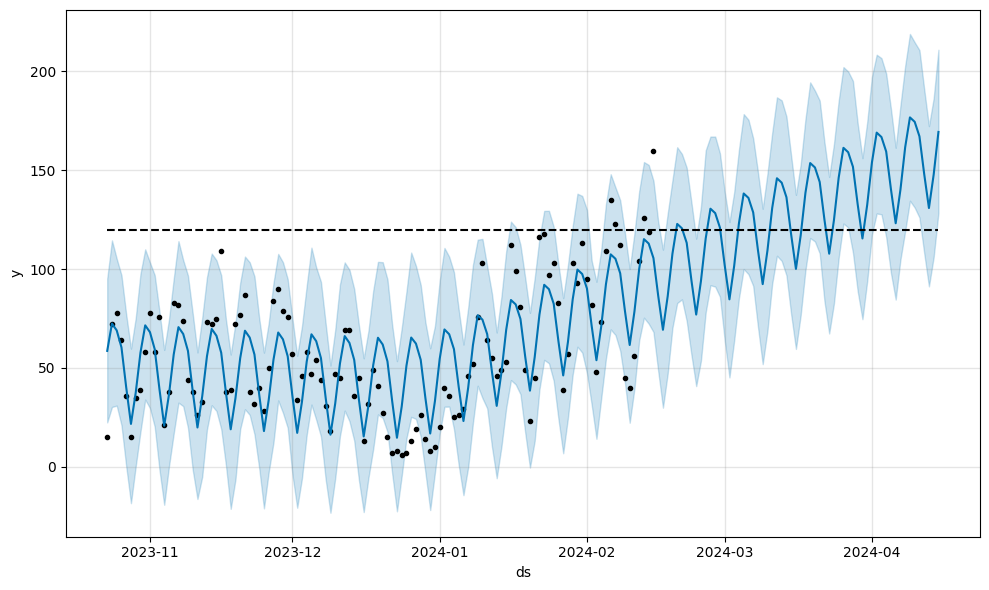

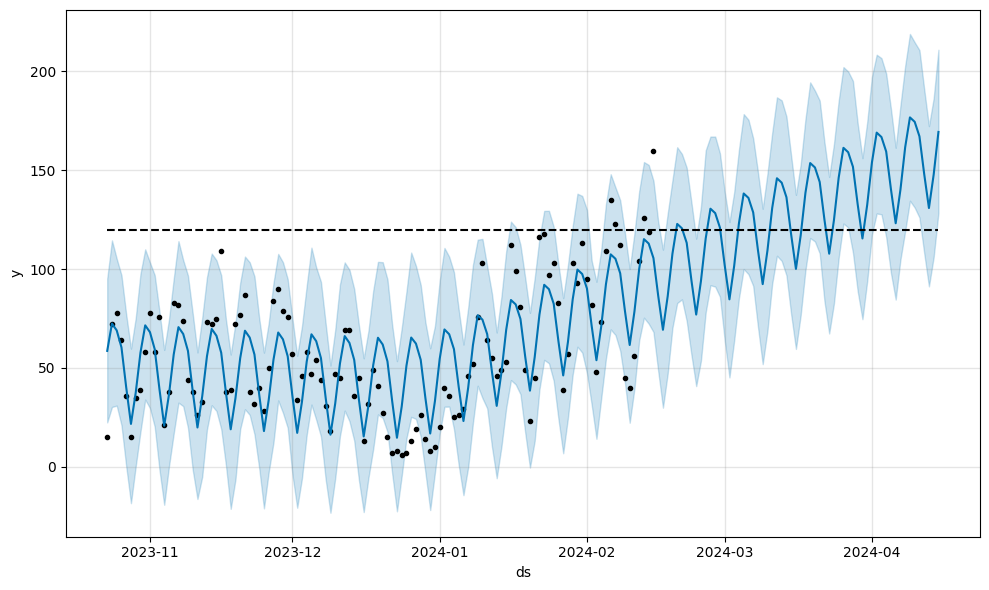

In [ ]:
#Output of the model
forecast = model.predict(future)
model.plot(forecast)

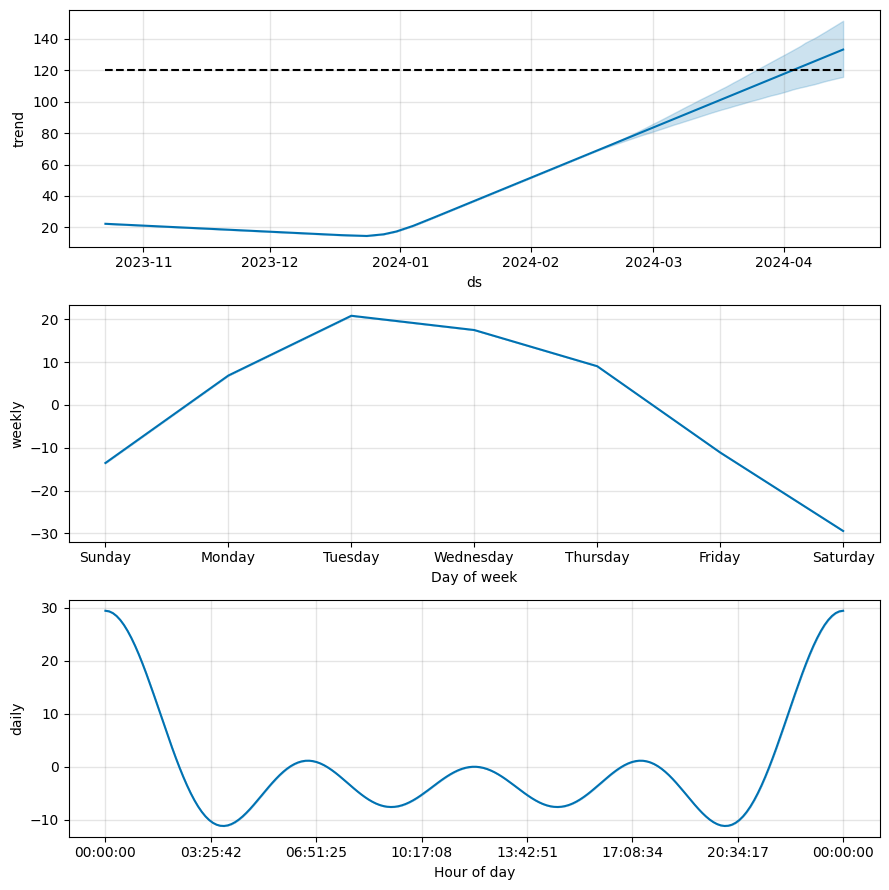

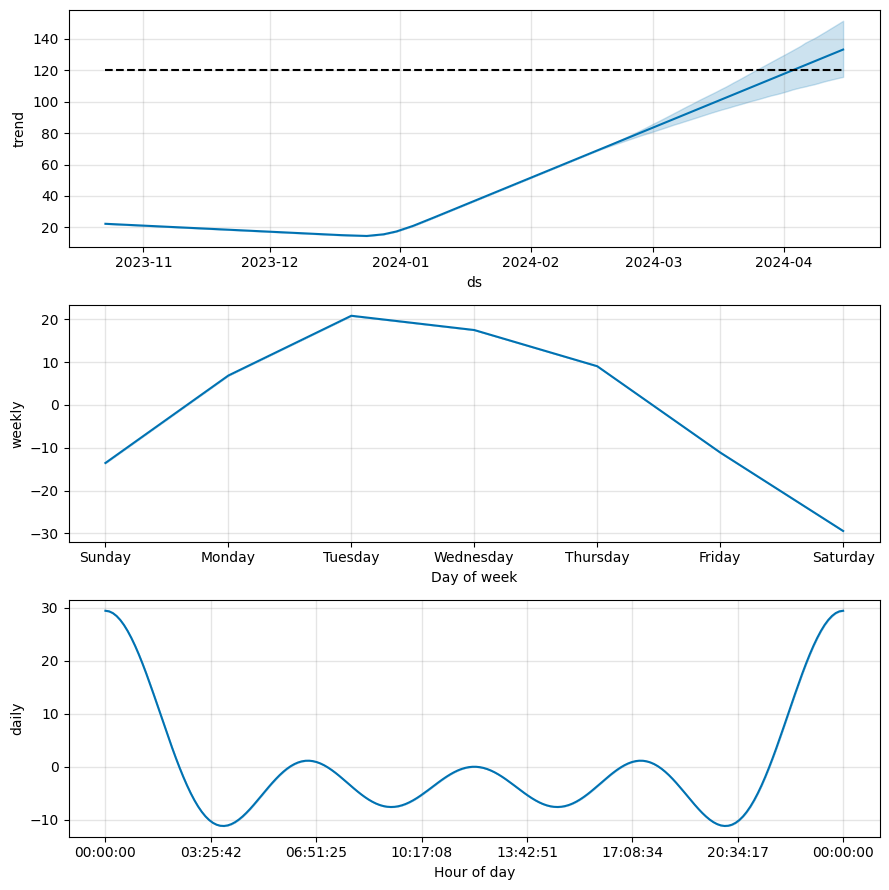

In [ ]:
#Output of various model components
model.plot_components(forecast)

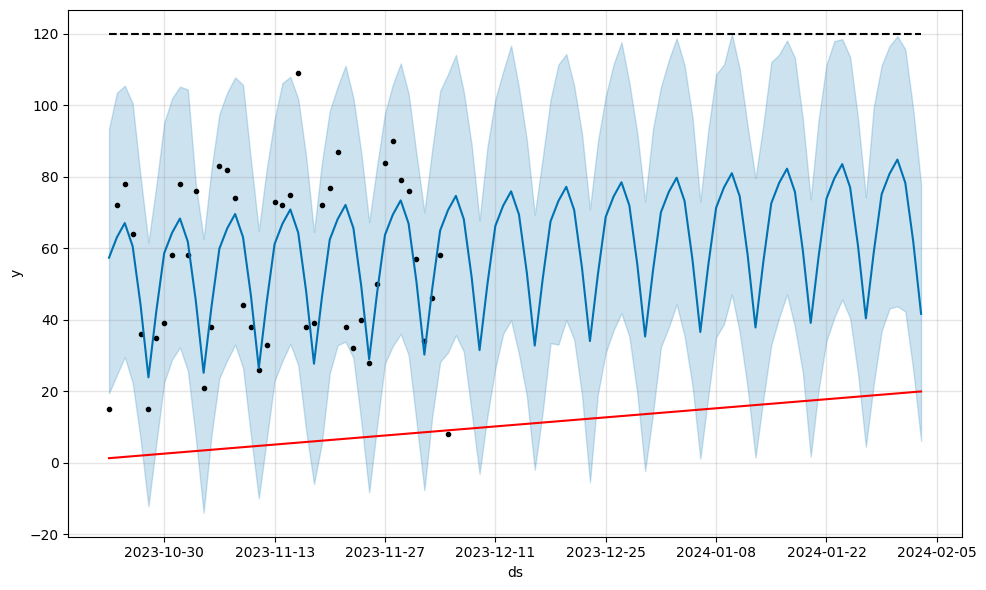

In [ ]:
#Plotting with a changepoints
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [ ]:
#Cross Validation
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '8 days', parallel="processes")
df_cv.head()

INFO:prophet:Making 21 forecasts with cutoffs between 2023-11-19 00:00:00 and 2024-02-07 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7aee4857bb80>
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ul48dz7/_donnuvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ul48dz7/slplvinw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ul48dz7/ncd5fko5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ul48dz7/pls6pvp5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10907', 'data', 'file=/tmp/tmp0ul48dz7/slplvinw.json', 'init=/tmp/tmp0ul48dz7/pls6pvp5.json', 'output', 'file=/tmp/tmp0ul48dz7/prophet_modelxiq1af9v/prophet_model-20

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-11-20,70.364054,41.901728,99.207294,77,2023-11-19
1,2023-11-21,88.861596,60.349854,118.823090,87,2023-11-19
2,2023-11-22,94.106361,65.409458,123.710119,38,2023-11-19
3,2023-11-23,86.596950,57.086929,113.963103,32,2023-11-19
4,2023-11-24,64.833578,36.012884,93.474837,40,2023-11-19


In [ ]:
# Performance metrics
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(20)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,595.800243,24.409020,19.674862,0.639208,0.344856,0.437908,0.904762
1,2 days,656.078725,25.614034,20.330831,0.481561,0.377642,0.423316,0.952381
2,3 days,1033.345861,32.145697,27.028141,0.766272,0.480330,0.566147,0.666667
3,4 days,1303.665124,36.106303,29.968179,0.912835,0.550299,0.651017,0.619048
4,5 days,826.886679,28.755637,23.902669,0.742250,0.390795,0.494570,0.809524
5,6 days,825.443438,28.730531,23.981890,0.602861,0.477331,0.515640,0.809524
6,7 days,1097.800959,33.133080,27.865308,0.803089,0.497686,0.597861,0.619048
7,8 days,1647.114263,40.584656,33.965269,0.994823,0.625173,0.708793,0.523810


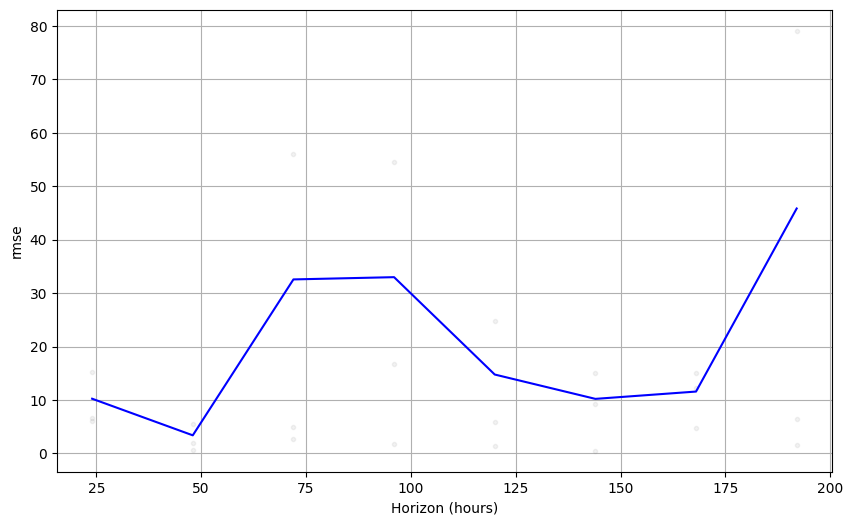

In [ ]:
# Visualizing the performance metrics
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')